# Porównawcza analiza wydajności architektur monolitycznej i mikroserwisowej

W tym notebooku przeprowadzam analizę porównawczą wydajności dwóch architektur systemów: **monolitycznej** oraz opartej o **mikroserwisy**. Porównanie wykonane jest na podstawie różnych metryk, takich jak przepustowość (RPS), opóźnienia i stabilność. Wyniki zostały zebrane wcześniej w fazie pomiarowej przy użyciu narzędzia **NBomber**.

# Metryki użyte w analizie

### Average RPS (średnia liczba żądań na sekundę)  
**Definicja:** Średnia arytmetyczna wartości RPS obliczonych dla każdej iteracji eksperymentu.  
**Znaczenie:** Określa przepustowość systemu, im wyższa wartość, tym lepsza wydajność.

---

### Average OK Requests Count (średnia liczba poprawnych żądań)  
**Definicja:** Średnia liczba żądań zakończonych sukcesem w każdej iteracji.  
**Znaczenie:** Wskazuje stabilność i niezawodność systemu.

---

### Average Failed Requests Count (średnia liczba błędnych żądań)  
**Definicja:** Średnia liczba żądań zakończonych błędem (status 4xx, 5xx).  
**Znaczenie:** Pomaga ocenić potencjalne problemy i przeciążenia systemu.

---

### Weighted Mean Latency (ważona średnia opóźnień)  
**Definicja:** Średnia ważona opóźnień z uwzględnieniem liczby żądań:

$$
\text{Weighted Mean Latency} = \frac{\sum_{i=1}^{n} (\text{średnia}_i \times \text{liczba żądań}_i)}{\sum_{i=1}^{n} \text{liczba żądań}_i}
$$

**Znaczenie:** Lepiej odzwierciedla rzeczywiste średnie opóź


# Procentowa zmiana latencji mikroserwisów względem monolitu

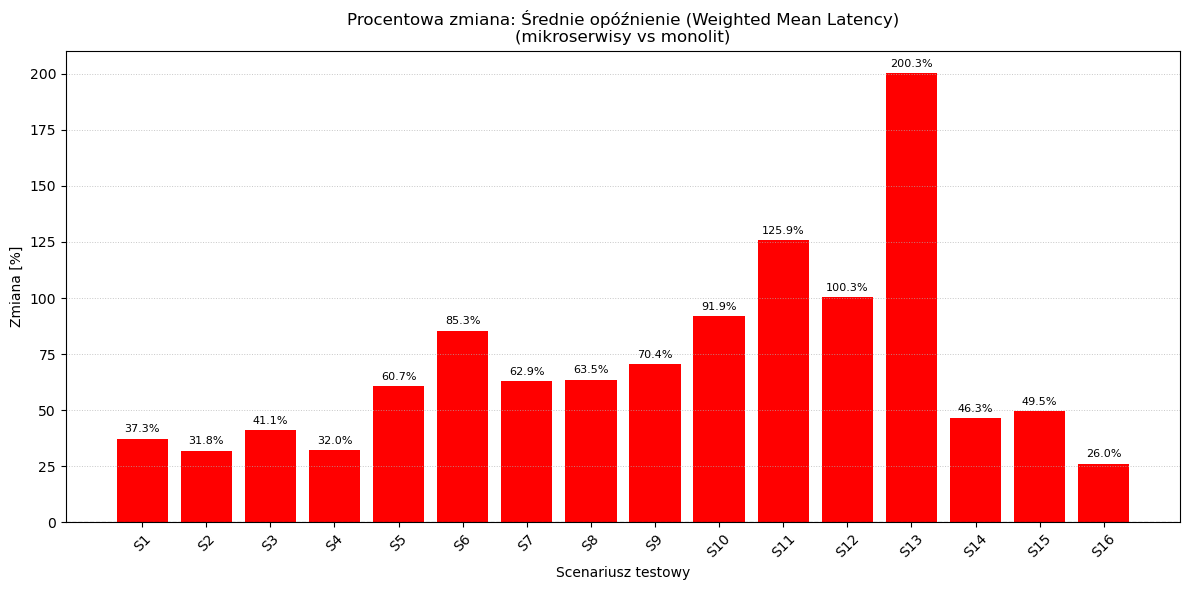

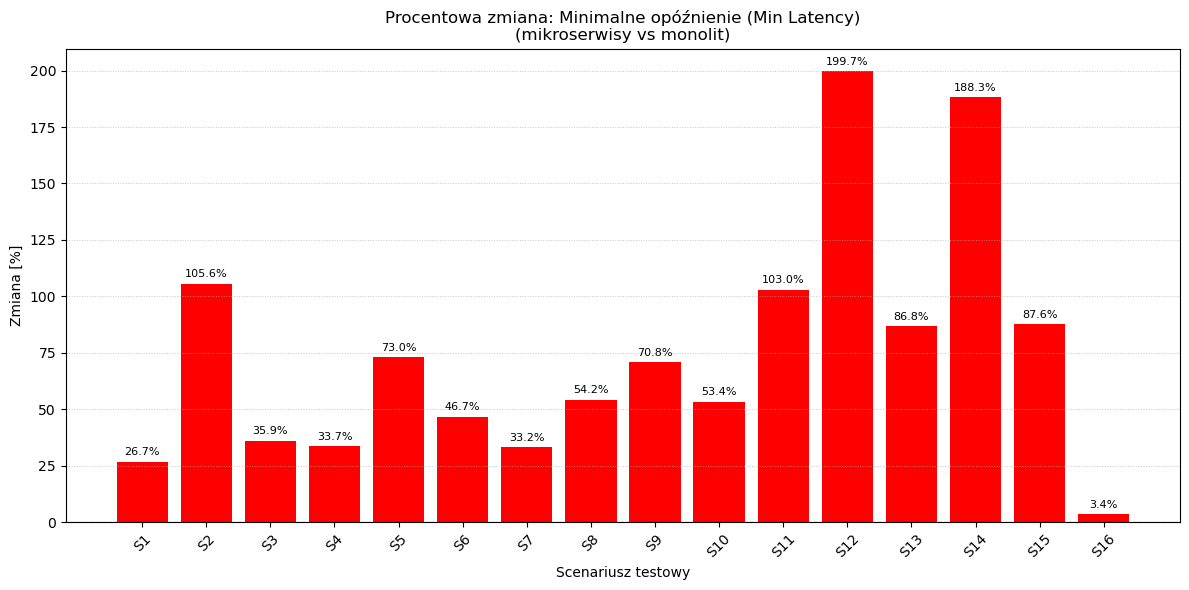

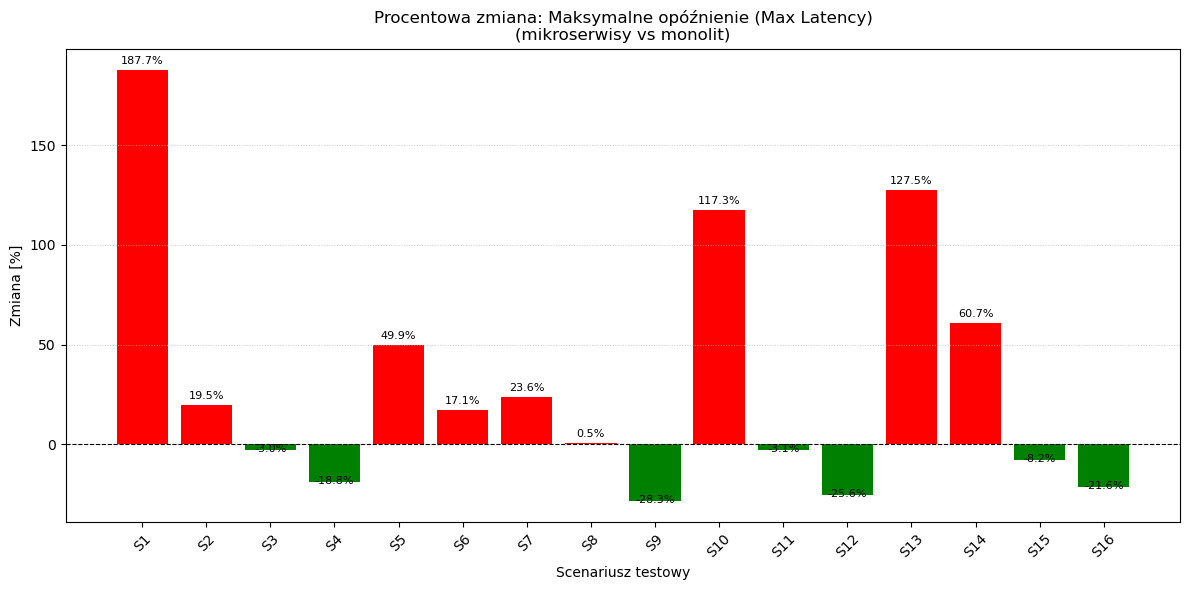

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Dane scenariuszy i latencje (średnia ważona, min, max)
scenarios = [f"S{i+1}" for i in range(16)]
data = {
    "Średnie opóźnienie (Weighted Mean Latency)": (
        [19.20, 193.23, 11.03, 91.56, 13.02, 114.22, 7.46, 62.25,
         50.53, 372.80, 23.87, 227.29, 148.68, 1492.25, 156.54, 1248.71],
        [26.36, 254.64, 15.56, 120.84, 20.92, 211.70, 12.15, 101.77,
         86.08, 715.31, 53.92, 455.21, 446.55, 2183.83, 234.01, 1573.03]
    ),
    "Minimalne opóźnienie (Min Latency)": (
        [2.85, 4.32, 2.81, 2.91, 1.96, 2.55, 2.08, 2.27,
         6.27, 9.51, 4.3, 6.92, 7.64, 461.06, 5.98, 13.25],
        [3.61, 8.88, 3.82, 3.89, 3.39, 3.74, 2.77, 3.5,
         10.71, 14.59, 8.73, 20.74, 14.27, 1329.08, 11.22, 13.7]
    ),
    "Maksymalne opóźnienie (Max Latency)": (
        [88.68, 706.25, 56.32, 511.25, 141.55, 473.54, 40.86, 321.26,
         525.11, 978.42, 153.22, 1321.02, 290.2, 1924.36, 592.67, 5852.65],
        [255.1, 843.66, 54.64, 415.09, 212.14, 554.48, 50.5, 322.86,
         376.52, 2126.59, 148.43, 983.07, 660.1, 3092.48, 544.33, 4585.57]
    )
}

def plot_latency_diff(title, monolith, microservices):
    delta_pct = [(micro - mono) / mono * 100 for mono, micro in zip(monolith, microservices)]
    colors = ['green' if val < 0 else 'red' for val in delta_pct]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(scenarios, delta_pct, color=colors)

    for bar, value in zip(bars, delta_pct):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + np.sign(height)*2,
                 f"{value:.1f}%", ha='center', va='bottom', fontsize=8)

    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.7)
    plt.title(f"Procentowa zmiana: {title}\n(mikroserwisy vs monolit)")
    plt.ylabel("Zmiana [%]")
    plt.xlabel("Scenariusz testowy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for label, (mono, micro) in data.items():
    plot_latency_diff(label, mono, micro)


## Porównanie opóźnień: mikroserwisy vs monolit

Powyższe wykresy przedstawiają procentową zmianę wartości opóźnień pomiędzy architekturą mikroserwisową a monolityczną dla 16 scenariuszy testowych. Dla każdej z metryk (Weighted Mean Latency, Min Latency, Max Latency) porównano, o ile procent wzrosły lub zmalały wartości w przypadku użycia mikroserwisów względem monolitu.

### Wnioski:
- W przypadku **Weighted Mean Latency** oraz **Max Latency** w większości scenariuszy obserwuje się **wyraźny wzrost opóźnień** w architekturze mikroserwisowej. Może to wynikać z narzutu komunikacji sieciowej między usługami (obsługa kolejek) oraz procesów działających w tle (obsługa Outbox Pattern).
- **Minimalne opóźnienie** w wielu przypadkach jest zbliżone, a nawet niższe w architekturze mikroserwisowej, co sugeruje, że mikroserwisy potrafią działać szybko w optymalnych warunkach.
- Wysokie wartości procentowe wzrostu w niektórych scenariuszach wskazują na **brak stabilności mikroserwisów** w ekstremalnych lub złożonych przypadkach.


# Porównanie przepustowości (RPS) i średnich ważonych opóźnień

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(conference_name, scenarios, micro_values, mono_values, ylabel, title, decimals=0, rotation=0):
    x = np.arange(len(scenarios))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, micro_values, width, label='Mikroserwisy', color='skyblue')
    bars2 = ax.bar(x + width/2, mono_values, width, label='Monolit', color='orange')

    ax.set_xlabel('Scenariusz')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=rotation)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    max_height = max([bar.get_height() for bar in bars1 + bars2])
    ax.set_ylim(top=max_height * 1.15)

    fmt = f'{{:.{decimals}f}}'
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + max_height * 0.02, fmt.format(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

scenarios = ['50VU KeepConstant', '500VU KeepConstant', '50VU RampingConstant', '500VU RampingConstant']

rps_data = {
    'BROWSE': {
        'micro': [2155.96, 2170.28, 1314.12, 1629.08],
        'mono': [3462.88, 3977.20, 2136.36, 2624.16]
    },
    'GET': {
        'micro': [1713.76, 1821.48, 1027.72, 1383.48],
        'mono': [2349.04, 2369.56, 1446.52, 1812.52]
    },
    'CREATE': {
        'micro': [528.68, 682.92, 300.12, 426.80],
        'mono': [896.96, 1266.28, 670.56, 787.00]
    },
    'UPDATE': {
        'micro': [106.72, 257.22, 75.60, 174.64],
        'mono': [308.40, 354.12, 112.04, 197.48]
    }
}

latency_data = {
    'BROWSE': {
        'micro': [20.92, 211.70, 12.15, 101.77],
        'mono': [13.02, 114.22, 7.46, 62.25]
    },
    'CREATE': {
        'micro': [86.08, 715.31, 53.92, 455.21],
        'mono': [50.53, 372.80, 23.87, 227.29]
    },
    'GET': {
        'micro': [26.36, 254.64, 15.56, 120.84],
        'mono': [19.20, 193.23, 11.03, 91.56]
    },
    'UPDATE': {
        'micro': [446.55, 2183.83, 234.01, 1573.03],
        'mono': [148.68, 1492.25, 156.54, 1248.71]
    }
}

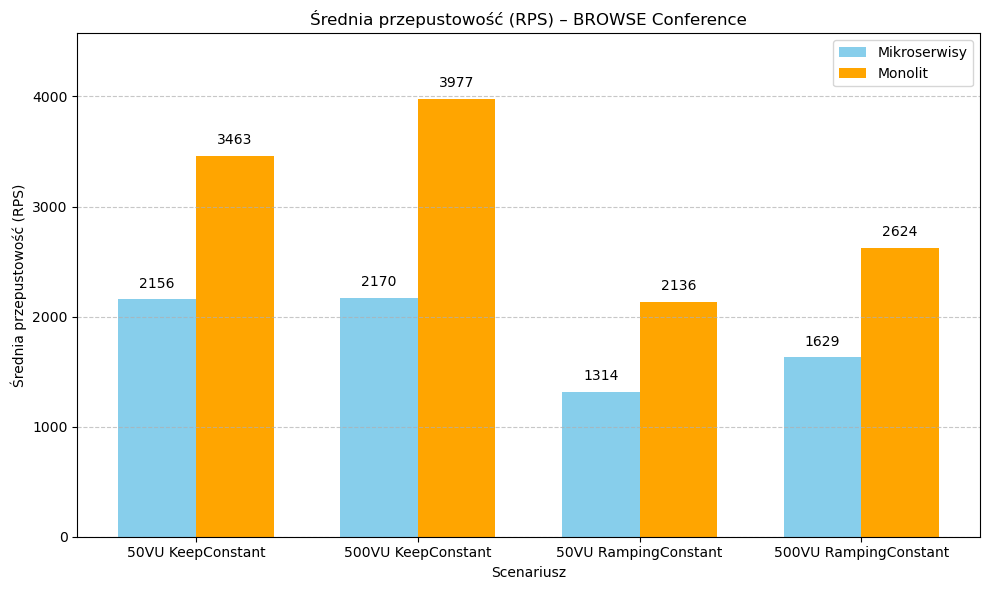

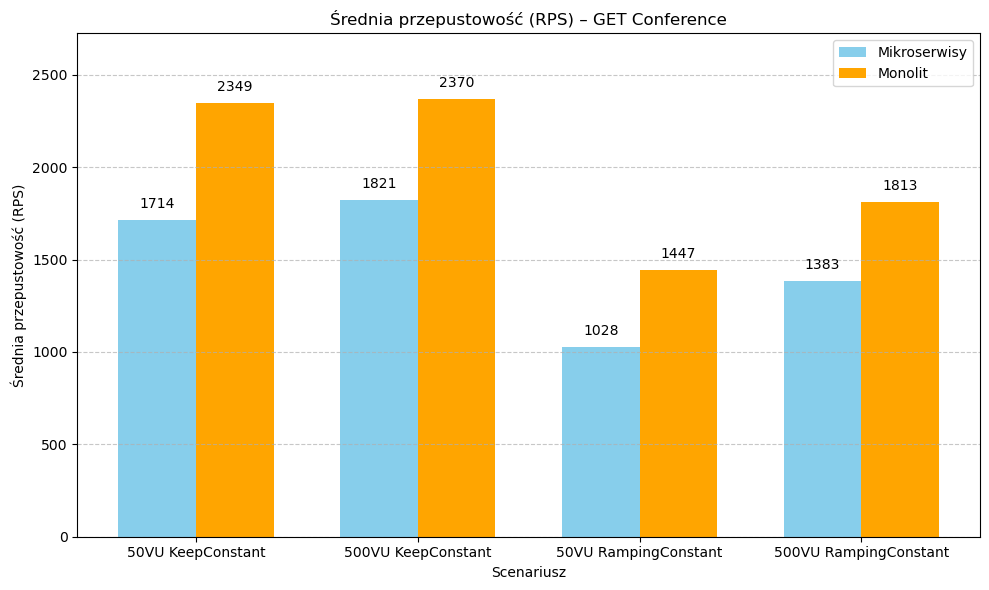

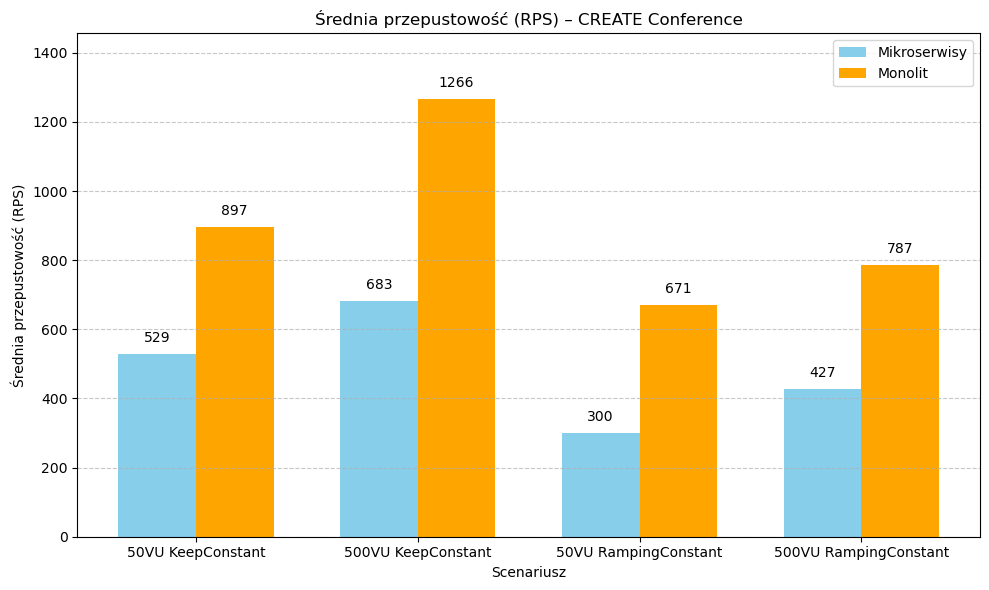

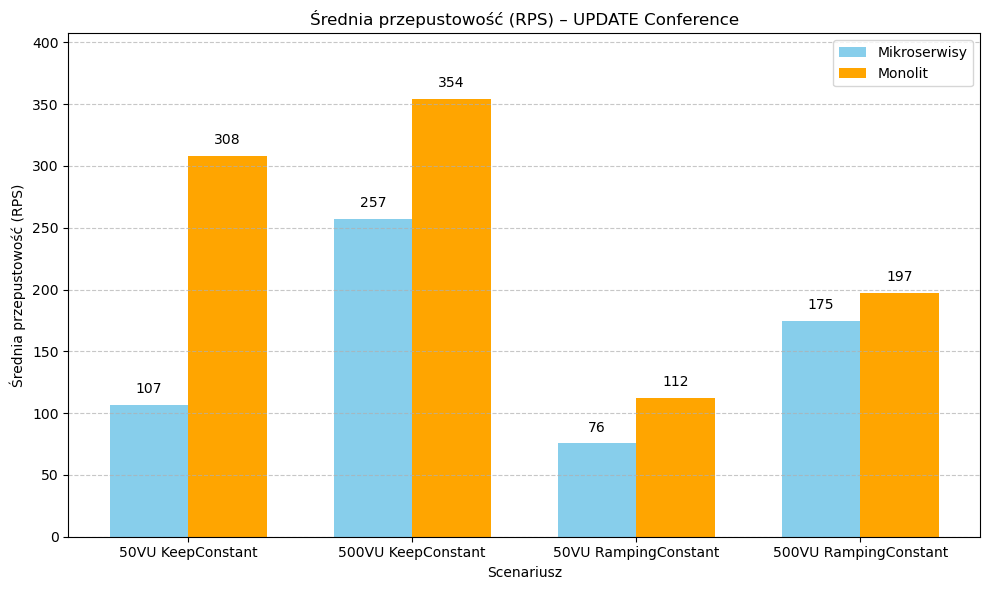

In [3]:
for conf in rps_data:
    plot_bar_chart(
        conference_name=conf,
        scenarios=scenarios,
        micro_values=rps_data[conf]['micro'],
        mono_values=rps_data[conf]['mono'],
        ylabel='Średnia przepustowość (RPS)',
        title=f'Średnia przepustowość (RPS) – {conf} Conference',
        decimals=0,
        rotation=0
    )

### Wnioski dla RPS (Requests Per Second):
- Architektura **monolityczna osiąga wyraźnie wyższe wartości RPS** we wszystkich rodzajach operacji i scenariuszach testowych.
- Największe różnice widoczne są w operacjach `CREATE` i `UPDATE`, co sugeruje, że mikroserwisy są mniej wydajne w przypadku zapisu i modyfikacji danych.
- Mikroserwisy mogą powodować większy narzut przy realizacji prostych operacji, zwłaszcza pod większym obciążeniem.

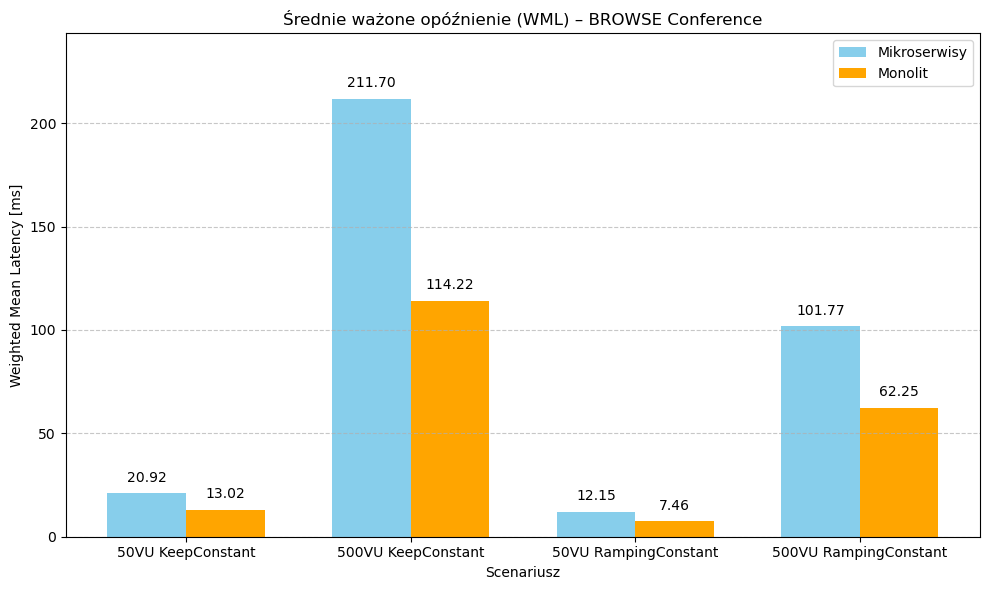

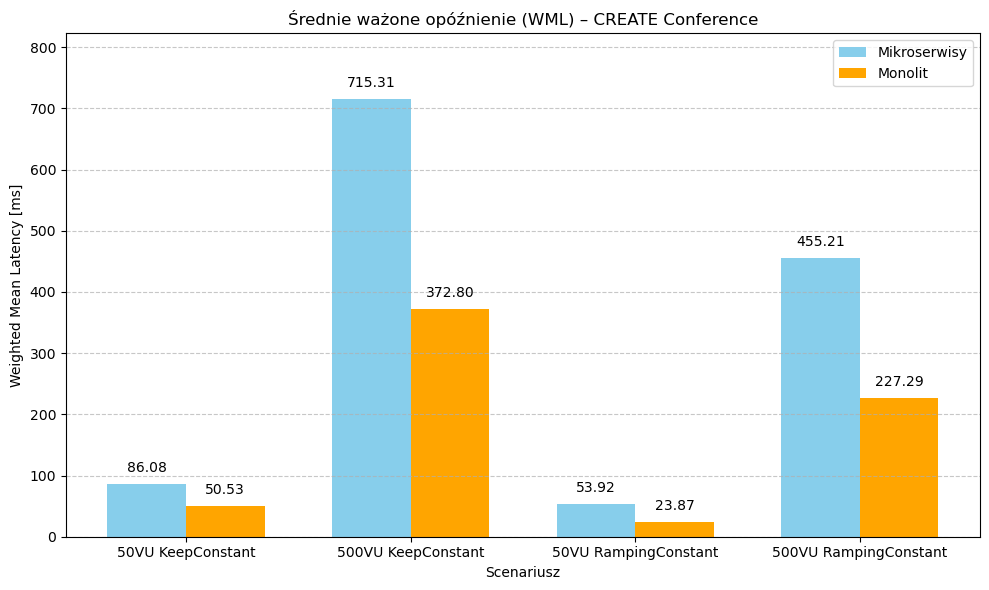

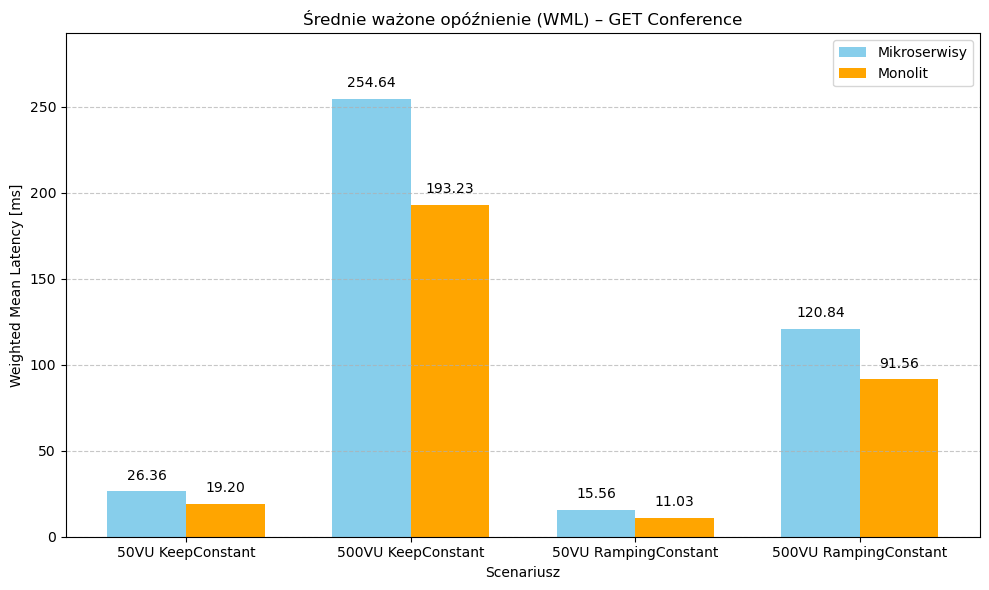

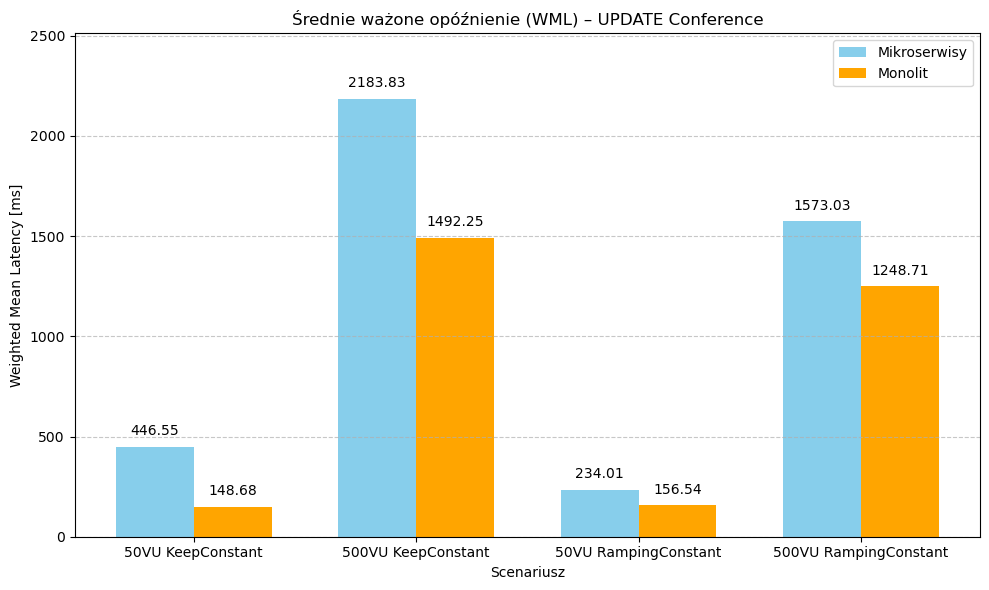

In [4]:
for conf in latency_data:
    plot_bar_chart(
        conference_name=conf,
        scenarios=scenarios,
        micro_values=latency_data[conf]['micro'],
        mono_values=latency_data[conf]['mono'],
        ylabel='Weighted Mean Latency [ms]',
        title=f'Średnie ważone opóźnienie (WML) – {conf} Conference',
        decimals=2,
        rotation=0
    )

### Wnioski dla Weighted Mean Latency:
- Mikroserwisy wykazują **większe wartości opóźnień średnich ważonych** we wszystkich typach operacji, szczególnie wyraźne dla `UPDATE` i `CREATE`.
- Wysokie latencje w mikroserwisach mogą być skutkiem **komunikacji między usługami**, co wydłuża całkowity czas przetwarzania.
- Dla operacji `BROWSE` i `GET` różnice są mniejsze, co sugeruje, że mikroserwisy mogą lepiej skalować się w przypadku prostych zapytań odczytu.